<a href="https://colab.research.google.com/github/Nkosana-263/Zindi-Challenges/blob/main/CGIAR%20Wheat%20Growth%20Stage%20Challenge/Zindi_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/My Drive/Colab Notebooks/Train.csv' Train.csv

In [ ]:
!cp '/content/drive/My Drive/Colab Notebooks/SampleSubmission.csv' SampleSubmission.csv

In [ ]:
!ls *.csv 

SampleSubmission.csv  Train.csv


In [ ]:
!cp 'drive/My Drive/Images.zip' images.zip 

In [ ]:
!unzip -q images.zip

In [ ]:
!pip install -q --upgrade fastcore 
!pip install fastai==2.0.13

     |████████████████████████████████| 51kB 3.0MB/s 
     |████████████████████████████████| 358kB 4.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage 
from fastai.vision.all import *

In [ ]:
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(10695, 3)


,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1


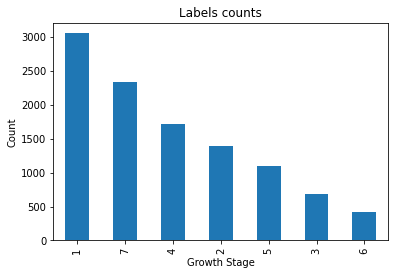

In [ ]:
 
train.growth_stage.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Growth Stage')
plt.ylabel('Count')
plt.show()

The images are named based on the UID. The growth_stage is our target colum - let's look at some examples:

<Figure size 432x288 with 0 Axes>

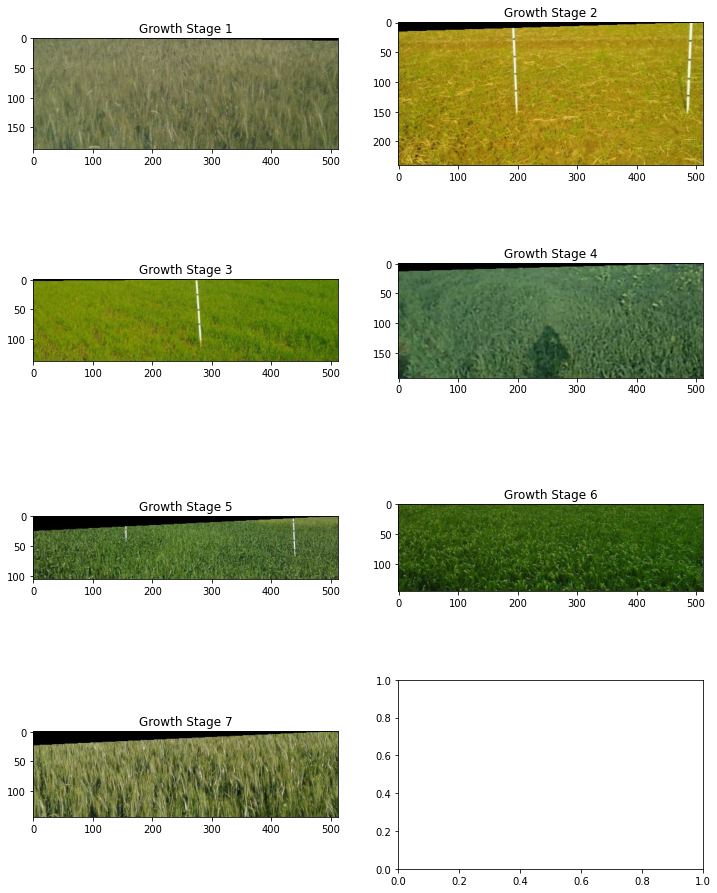

In [ ]:
plt.figure()
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
 
for i, ax in enumerate(axs.flatten()):
  if i+1 in train['growth_stage'].unique():
    im_id = train.loc[(train.growth_stage == i+1)].sample()['UID'].values[0]
    im = PImage.open(f'Images/{im_id}.jpeg')
    ax.imshow(im)
    ax.set_title( f'Growth Stage {i+1}')

In [ ]:
train.loc[train.label_quality == 2].shape[0]

2856

In [ ]:
import numpy as np

In [ ]:
!pip install nbdev

     |████████████████████████████████| 51kB 2.5MB/s 


In [ ]:
train_hq = train.loc[train.label_quality == 2]

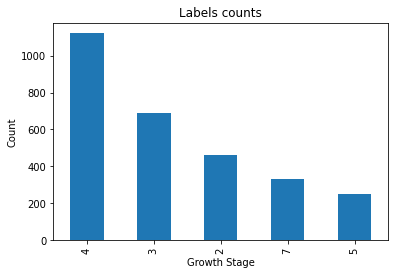

In [ ]:
 
train_hq.growth_stage.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Growth Stage')
plt.ylabel('Count')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(train_hq,random_state=2)

In [ ]:
 ncat_bal = train_hq['growth_stage'].value_counts().max()

In [ ]:
 train_hq = train_hq.groupby('growth_stage', as_index=False).apply(
     lambda g:  g.sample(ncat_bal, replace=True, random_state=24)
     ).reset_index(drop=True)

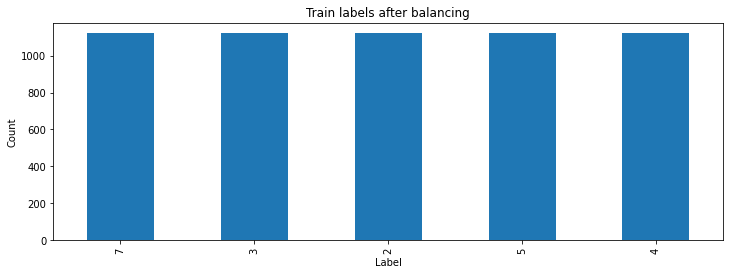

In [ ]:
 
f, ax = plt.subplots(figsize=(12,4))
         
# After balancing
train_hq.growth_stage.value_counts().plot(kind='bar')
ax.set_title('Train labels after balancing')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
plt.show()

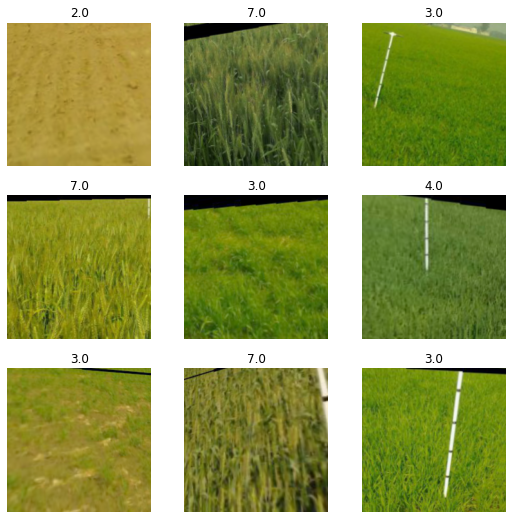

In [ ]:
 
np.random.seed(1)
data = ImageDataLoaders.from_df(train_hq, 
                                path='Images/', suff='.jpeg', label_col='growth_stage', 
                                item_tfms=Resize(224),y_block=RegressionBlock, 
                                batch_tfms=aug_transforms(), bs=32, valid_pct=0.15)
data.show_batch()

# Model based on resnet152 architecture

In [ ]:
import torchvision.models as models

In [ ]:
model = models.resnet152

In [ ]:
resnet = cnn_learner(data,model,metrics=rmse)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=1.0964781722577754e-06)

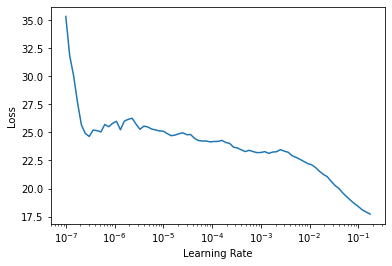

In [ ]:
resnet.lr_find()

In [ ]:
 with resnet.no_mbar():
    resnet.fit(n_epoch=100, base_lr=1.7e-2)

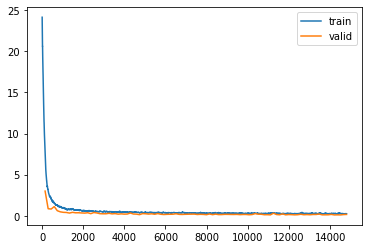

In [ ]:
resnet.recorder.plot_loss()

In [ ]:
 resnet.save('model_1')

Path('Images/models/model_1.pth')

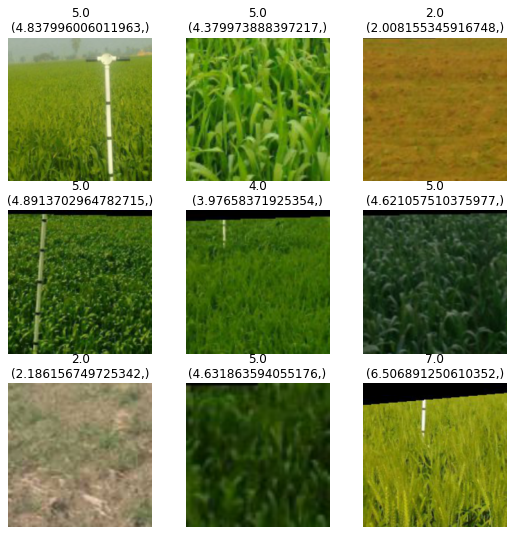

In [ ]:
resnet.show_results()

In [ ]:
resnet.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 128 x 56 x 56   8,192      True      
________________________________________________________________
BatchNorm2d          64 x 128 x 56 x 56   256        True      
________________________________________________________________
Conv2d               64 x 128 x 56 x 56   147,456    True      
_________________________________________________

# Model based on densenet201 architecture

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=5.248074739938602e-05)

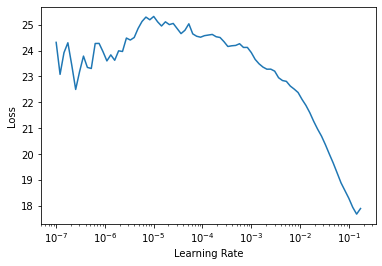

In [ ]:
 
model = models.densenet201
 
densenet = cnn_learner(data,model,metrics=rmse)
 
densenet.lr_find()

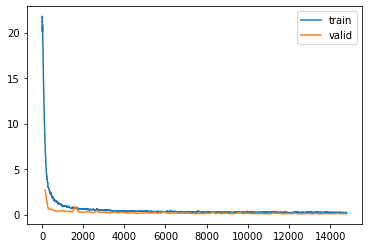

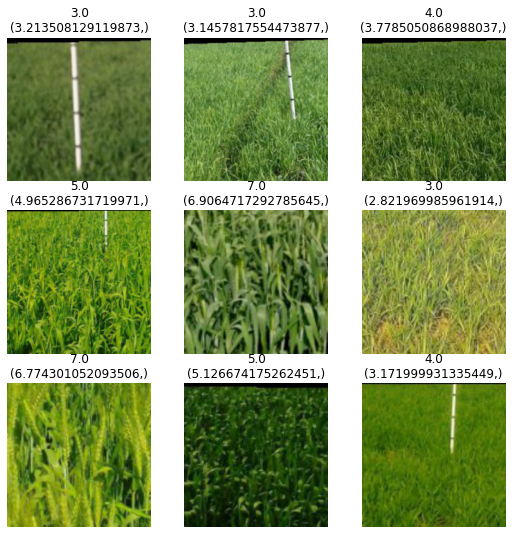

In [ ]:
 with densenet.no_mbar():
    densenet.fit(n_epoch=100, base_lr=1.4e-2)
 
densenet.recorder.plot_loss()
densenet.show_results()

# Model based on Resnext101 architecture

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.03981071710586548)

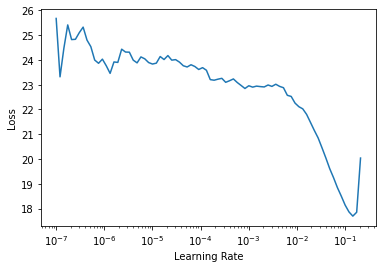

In [ ]:
model = models.resnext101_32x8d
resnext = cnn_learner(data,model,metrics=rmse)
 
resnext.lr_find()

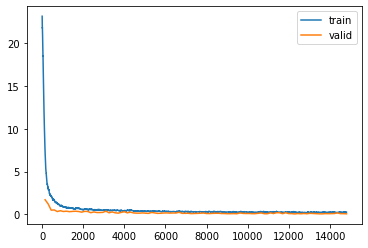

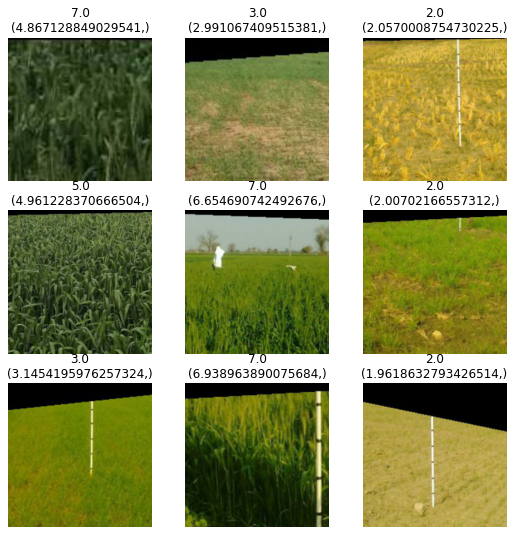

In [ ]:
with resnext.no_mbar():
    resnext.fit(n_epoch=100, base_lr=1.4e-2)
 
resnext.recorder.plot_loss()
resnext.show_results()

# Saving Predictions

In [ ]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,UID,growth_stage
0,F3LbWkZq,0
1,6P4wLVzI,0
2,Tn6HIrdS,0
3,EYM5R1TK,0
4,fkcevlA0,0


In [ ]:
def get_preds(model_name):
  tdl = model_name.dls.test_dl(ss)  # make test dataloader

  return model_name.tta(dl=tdl)  # get model's predictions

In [ ]:
# preds = get_preds(densenet)
# preds = get_preds(resnet)
preds = get_preds(resnext)

In [ ]:
ss['growth_stage'] = preds[0].numpy()
ss.head()

,UID,growth_stage
0,F3LbWkZq,4.266956
1,6P4wLVzI,4.554914
2,Tn6HIrdS,3.039884
3,EYM5R1TK,4.284423
4,fkcevlA0,6.034602


In [ ]:
ss.to_csv('resnext.csv', index=False)

In [ ]:
from google.colab import files
 
files.upload()

Saving ensemble_3.csv to ensemble_3.csv


{'ensemble_3.csv': b'UID,growth_stage\nF3LbWkZq,4.3205634625\n6P4wLVzI,3.9371891249999997\nTn6HIrdS,2.6249843125\nEYM5R1TK,4.152674975\nfkcevlA0,5.027455874999999\nQumzsyqU,3.761476775\nI5axlwYR,2.8909397749999997\nC95wnKFx,1.9979960625\n79kzEdvF,3.8475540875\nYSCVBnkr,3.5359877749999997\nZmw5jCv8,3.0629287749999996\na1dESxDL,6.9219403999999995\nyxR8khFG,3.7003038625\nqiAeBInp,2.7208176375\nnlsuxPb1,3.5017291750000004\nQipL41yR,2.148147475\nez51RTAd,2.3214102499999996\nOHs5wU4D,3.8014475125\n8mAFW0O5,4.3107787250000005\nh1q6dJaE,3.1401199875000003\nlzbf64tR,2.8138298\nfbFrvuMy,5.3030893500000005\nYL9uPlKQ,4.2815150375\n3fmyxTPW,4.7160884125\nTRiWtzmH,3.6705176125000003\nea5vKYbg,3.39020365\nev4J9Znk,3.3002068125\nJlzBWAiQ,6.98676205\n02r3NCOn,3.92156685\n5yzDhIG9,1.9664254999999997\nuFov7HMj,1.9759844125\nMdbf7phC,4.5154008\nXEqn72xH,5.001876149999999\nyOpjAIEd,4.0098478125\ncsKGjRnZ,3.7990550875\nsLmqi4MF,3.5216452625000003\nn4x93S0A,4.117616675000001\ncjLbHRd2,2.2259153625000003\n5yB

# Ensemble

In [ ]:
weights = [0.40, 0.40, 0.20]

In [ ]:
sub2 = pd.read_csv('densenet201.csv')
sub3 = pd.read_csv('resnext.csv')
sub4 = pd.read_csv('resnet152.csv')
merged = pd.merge(sub2, sub3, on='UID') # Will give 3 columns of preds - growth_stage_x, growth_stage_y an growth_stage_z
merged = pd.merge(merged, sub4, on='UID')
x,y,z = weights
merged['growth_stage_z'] = merged['growth_stage']
merged['growth_stage'] = x*merged['growth_stage_x'] + y*merged['growth_stage_y'] + z*merged['growth_stage_z']
merged[['UID', 'growth_stage']].to_csv('Submission.csv', index=False)